In [7]:
import pennylane as qml

from pennylane import numpy as np

import matplotlib.pyplot as plt

dev = qml.device('default.mixed', wires = 1)

Gamma_ps_global = 0

In [8]:
# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [9]:
@qml.qnode(dev)
def circuit(phi_in):
    qml.Hadamard(wires=0)
    
    qml.ApproxTimeEvolution(hamiltonian, -phi_in/2, 1)
    
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires = 0)

In [10]:
@qml.qnode(dev)
def Post_selection(phi):
    global Gamma_ps_global
    Gamma_ps = Gamma_ps_global
    
    density_matrix = np.zeros((2, 2), dtype=np.complex128)
    density_matrix = circuit(phi)
    
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=0)
    
    return qml.density_matrix(wires=0)

In [11]:
PHI_sweep = np.arange(1e-3, 3 * np.pi + 1e-3, 1e-2)
CFI_DATA = np.zeros(len(PHI_sweep))

Gamma_ps_global = 0.9

for i in range(len(PHI_sweep)):
    CFI_DATA[i] = qml.qinfo.classical_fisher(Post_selection)(PHI_sweep[i])

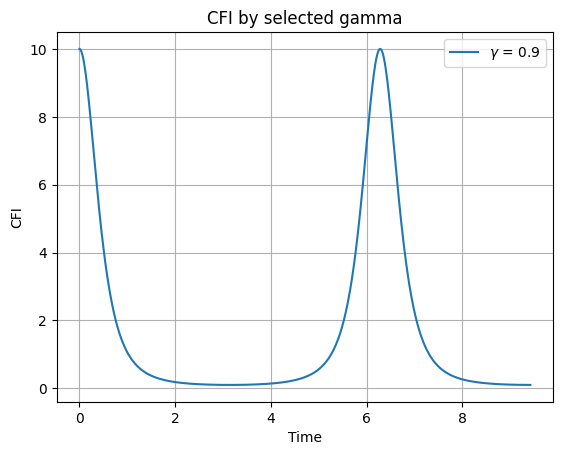

In [12]:
plt.plot(PHI_sweep, CFI_DATA, label = f'$\gamma$ = {Gamma_ps_global}')

plt.title('CFI by selected gamma')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()